In [20]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt

from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from utils_fdm import *
from sklearn.model_selection import train_test_split

In [21]:
#PARAMETROS DO MODELO
D = 0.0039
P = 0.0453
C0 = 8e3
ALPHA = 0.0305
AB = 10

#DOMINIO DO MODELO
L = 20
TF = 80

#QUANTIDADE DE NÓS DO DOMÍNIO
N_X = 50
N_T = TF

#PLANO DE TRATAMENTO DIAS X DOSES
DAYS = [
    [],
    [0,1], # Um dia +1 da dose extra
    [i for i in range(6)], # Dois dias +1 da dose extra
    [i for i in range(21)],
    [i for i in range(28)],
    [i for i in range(35)]
]
DOSES = [
    [],
    [60.0, 4.2],
    [12.2, 12.2, 12.2, 12.2, 12.2, 3.2],
    [2.8, 2.8, 2.8, 2.8, 2.8, 0.0, 0.0, 3.5, 3.5, 3.5, 3.5, 3.5, 0.0, 0.0, 6.5, 6.5, 6.5, 6.5, 6.5, 0.0, 0.0],
    [2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.9, 2.9, 2.9, 2.9, 2.9, 0.0, 0.0, 3.0, 3.0, 3.0, 3.0, 3.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0],
    [1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0, 1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0, 1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0, 1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0, 1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0]
]

#DICIONÁRIO DOS PARÂMETROS
PARAMS = Params(D, P, L, TF, C0, ALPHA, AB)

#VARIAVEIS E CONDIÇÃO INICIAL
X = np.linspace(0, 1, N_X, dtype = np.float32) 
T = np.linspace(0, PARAMS['tf'] * PARAMS['p'], N_T) 

#PROCESSO GAUSSIANO

def Random_functions(x, state):
    seed = MasterRNG(state)
    model = Gaussian(dim=1, var=50, len_scale=0.6)
    srf= SRF(model, seed=seed())
    f = srf.structured([x])
    return f


def data_generate(n_ics, X, T, nx, state):
    
    print(f'----------Gerando Base de Dados Nº amostras: {n_ics}------------')
    # CONDIÇÕES INICIAIS ALEATÓRIAS VIA PROCESSO GAUSSIANO
    ics = np.zeros((n_ics, nx))
    for fn in range(n_ics):
        x_values = Random_functions(X, state)
        ics[fn, :] = x_values

    # GERANDO SOLUÇÕES PARA DIFERENTES CONDIÇÕES INICIAIS
    S = []
    for i in range(n_ics):
        X, T, SOLUTION = Solve(DAYS[0], DOSES[0], PARAMS, X, T, ics[i], False, 40)
        S.append(SOLUTION)

    S = np.array(S)
    S = S * (C0 / L**3)

    # CONSTRUÇÃO DA BASE DE DADOS
    # BRANCH DATA
    branch = ics

    # TRUNK DATA
    trunk = []
    for i in T:
        for j in X: 
            trunk.append([i, j])
    trunk = np.array(trunk)

    # TARGET DATA
    target = []
    for i in range(len(ics)):
        target.append(S[i].flatten())
    target = np.array(target)

    return branch, trunk, target


branch_train, trunk_train, target_train = data_generate(250, X, T, N_X, 123)
branch_test, trunk_test, target_test = data_generate(150, X, T, N_X, 123)
branch_train.shape, trunk_train.shape, target_train.shape, branch_test.shape, trunk_test.shape, target_test.shape

----------Gerando Base de Dados Nº amostras: 250------------
----------Gerando Base de Dados Nº amostras: 150------------


((250, 50), (4000, 2), (250, 4000), (150, 50), (4000, 2), (150, 4000))

In [22]:
# DADOS 
branch_train = branch_train.astype(np.float32)
trunk_train = trunk_train.astype(np.float32)
target_train = target_train.astype(np.float32)
branch_test = branch_test.astype(np.float32)
trunk_test = trunk_test.astype(np.float32)
target_test = target_test.astype(np.float32)

X_TRAIN, Y_TRAIN = (branch_train, trunk_train), target_train
X_TEST, Y_TEST = (branch_test, trunk_test), target_test

In [23]:
#GPU
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

data = dde.data.Triple(X_train= X_TRAIN, y_train = Y_TRAIN, X_test= X_TEST, y_test = Y_TEST)

net = dde.nn.DeepONetCartesianProd(
    [N_X, 150, 150, 150, 40],
    [2, 150, 150, 150, 40],
    'relu',
    'Glorot normal',
)
  
model = dde.Model(data, net)
model.compile('adam', lr = 1e-3)

Compiling model...
'compile' took 0.000307 s



In [24]:
loss_history, train_state = model.train(iterations = 50000)

Training model...

Step      Train loss    Test loss     Test metric
0         [1.12e+04]    [1.12e+04]    []  
1000      [9.41e-01]    [9.41e-01]    []  
2000      [4.92e-01]    [4.92e-01]    []  
3000      [9.83e-02]    [9.83e-02]    []  
4000      [1.48e-01]    [1.48e-01]    []  
5000      [1.50e+00]    [1.50e+00]    []  
6000      [6.02e-01]    [6.02e-01]    []  
7000      [6.90e-01]    [6.90e-01]    []  
8000      [1.96e+00]    [1.96e+00]    []  
9000      [5.19e-02]    [5.19e-02]    []  
10000     [5.97e+00]    [5.97e+00]    []  
11000     [1.66e+00]    [1.66e+00]    []  
12000     [4.62e-01]    [4.62e-01]    []  
13000     [3.70e-01]    [3.70e-01]    []  
14000     [9.95e-01]    [9.95e-01]    []  
15000     [1.18e+00]    [1.18e+00]    []  
16000     [9.51e-01]    [9.51e-01]    []  
17000     [3.46e-01]    [3.46e-01]    []  
18000     [5.55e-02]    [5.55e-02]    []  
19000     [1.23e-01]    [1.23e-01]    []  
20000     [1.01e-02]    [1.01e-02]    []  
21000     [5.75e-01]    [5.7

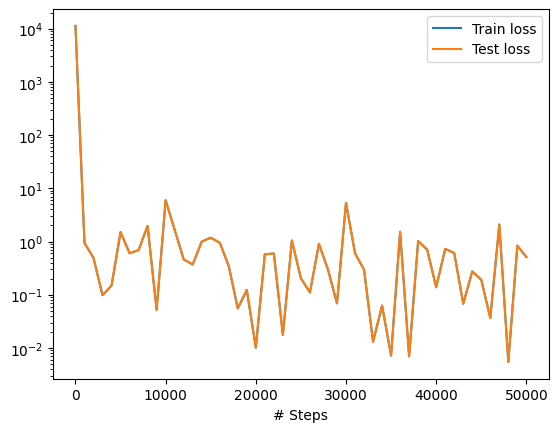

In [25]:
dde.utils.plot_loss_history(loss_history) 

In [26]:
trunk = []
for i in T:
    for j in X:
        trunk.append([i, j])
trunk = np.array(trunk)

ic = L**3 * np.exp(-100 * X**2)

branch  = [
    ic
]

branch = np.array(branch)
trunk = trunk.astype(np.float32)
branch = branch.astype(np.float32)

#plt.plot(branch)
branch.shape, trunk.shape

((1, 50), (4000, 2))

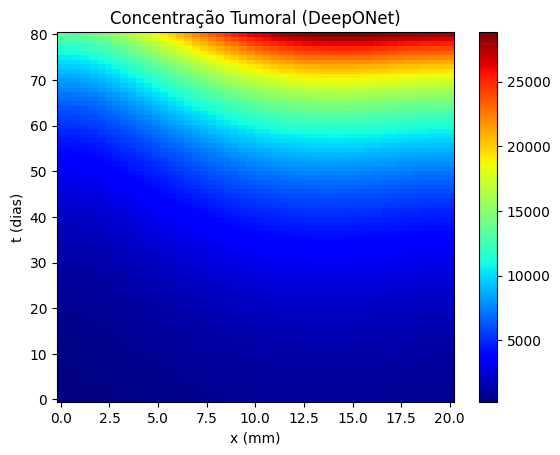

In [27]:


#trunk = []
#branch = []
#for i in T:
#    for j in X:
#        trunk.append([i, j])
#        branch.append(ic)
#trunk = np.array(trunk)
#branch = np.array(branch)


trunk = trunk.astype(np.float32)
#branch = ic.astype(np.float32)

result = model.predict((branch, trunk))
result = result.reshape(N_T, N_X)

plt.pcolormesh(X * L, T / P, result, cmap = 'jet')
plt.colorbar()
plt.xlabel('x (mm)')
plt.ylabel('t (dias)')
plt.title('Concentração Tumoral (DeepONet)')
plt.show()
